In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv("data/titanic_train.csv")
test = pd.read_csv("data/titanic_test.csv")

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train.info()

In [4]:
train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Graham, Mr. George Edward",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [ ]:
from sklearn.preprocessing import minmax_scale
from pandas.plotting import scatter_matrix

num_cols = ["SibSp", "Parch", "Fare"]

scatter_matrix(train[cols], alpha=0.5, figsize=(10, 10))
plt.show()

In [ ]:
scaled_cols = ["SibSp_scaled", "Parch_scaled", "Fare_scaled"]

for i in range(len(columns)):
    train[scaled_cols[i]] = minmax_scale(train[num_cols[i]])
    test[scaled_cols[i]] = minmax_scale(test[num_cols[i]])

In [ ]:
train["Embarked"] = train["Embarked"].fillna("S")
test["Embarked"] = test["Embarked"].fillna("S")

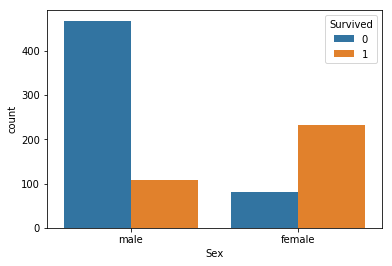

In [6]:
sns.countplot(x="Sex", hue="Survived", data=train)

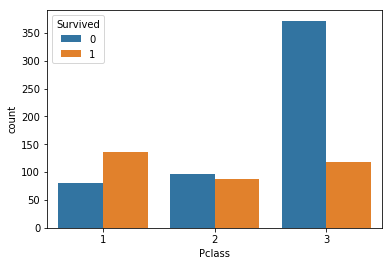

In [7]:
sns.countplot(x="Pclass", hue="Survived", data=train)

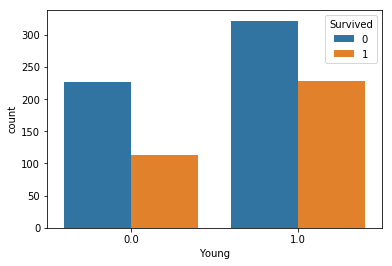

In [21]:
train.loc[train["Age"]<30, "Young"] = 1
train["Young"].fillna(0,inplace=True)
sns.countplot(x="Young", hue="Survived", data=train)

In [ ]:
test_ids = test["PassengerId"]
submission_df = {"PassengerId": test_ids, "Survived": test_predictions}
submission = pd.DataFrame(submission_df)

submission.to_csv("submission.csv", index=False)